# NHANES Diabetes Prediction Model
- 1 in 5 people don't know they have diabetes. 
- Diabetes is the #8 leading cause of death in the United States. 
- People with diabetes pay 2x higher medical bills  

Creating accurate predictive models to help individuals quickly identify diabetes could be pivotal in their lives, and help get them medical attention. 

## Read in Libraries

In [141]:
# load in necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

## Read in the Data
Note: Data pre-processed in R and saved to csv to use for further analysis here.

In [80]:
data = pd.read_csv('nhanes_cleaned.csv')
data.head()

,Unnamed: 0,blood_cholesterol_mg_per_dc,blood_glycosylated_hemoglobin_volume_percentage,family_income,household_adults_60_years_plus,household_children_6_17_years,household_income,household_ref_person_age_year,household_ref_person_biological_sex,household_ref_person_education,...,subject_education,subject_high_blood_pressure,subject_2_year_weight_screening_time,subject_2_year_mec_weight_mec_time,subject_insurance,subject_masked_variance_pseudo_psu,subject_masked_variance_pseudo_stratum,subject_prescription_coverage,subject_race_ethnicity,diagnosis
0,4331,168,5.5,"$65,000 to $74,999",1,0,"$65,000 to $74,999",61,2,College graduate or above,...,College graduate or above,Yes,60325.09525,61758.65488,Covered by state-sponsored health plan,1,114,Yes,White Hispanic,False
1,4332,168,5.2,"$100,000 and Over",0,0,"$100,000 and Over",26,2,College graduate or above,...,College graduate or above,No,89514.43322,91523.51605,Covered by private insurance,2,113,Yes,White Hispanic,False
2,4333,131,5.0,"$45,000 to $54,999",0,1,"$45,000 to $54,999",33,2,College graduate or above,...,College graduate or above,No,14155.31300,15397.21985,Covered by private insurance,2,114,Yes,Non-White,False
3,4334,154,5.1,"$45,000 to $54,999",0,2,"$45,000 to $54,999",35,2,Some college or AA degree,...,9th grade,No,12433.74874,12665.77009,Covered by private insurance,1,104,Yes,White Hispanic,False
4,4336,225,5.8,"$20,000 and Over",0,3,"$20,000 and Over",38,2,High school graduate/GED or equivalent,...,High school graduate/GED or equivalent,No,27388.92069,27196.63839,Covered by private insurance,2,116,Yes,White Hispanic,False


## Further Data Pre-processing

In [81]:
# Define numerical and categorical features
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## Create Model

In [82]:
# Create a new model using TensorFlow/Keras, more similar to your class example
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=[input_shape]),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Split Data and Fit

In [83]:
# Split data into X and y
X = data.drop('diagnosis', axis=1)
y = data['diagnosis'].astype(int)  # for binary classification

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the preprocessor to the training data and transform it
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Further split the training data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_transformed, y_train, test_size=0.2, random_state=42)

# Get the number of features from the transformed data
input_shape = X_train_transformed.shape[1]

## Build and Fit Model

In [84]:
# Build the model
model = build_model(input_shape)

# Fit the model
h = model.fit(X_train_final, y_train_final, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
68/68 [==============================] - 1s 5ms/step - loss: 0.2885 - accuracy: 0.8994 - val_loss: 0.2008 - val_accuracy: 0.9320
Epoch 2/10
68/68 [==============================] - 0s 3ms/step - loss: 0.1802 - accuracy: 0.9407 - val_loss: 0.1774 - val_accuracy: 0.9430
Epoch 3/10
68/68 [==============================] - 0s 2ms/step - loss: 0.1530 - accuracy: 0.9472 - val_loss: 0.1908 - val_accuracy: 0.9375
Epoch 4/10
68/68 [==============================] - 0s 3ms/step - loss: 0.1367 - accuracy: 0.9527 - val_loss: 0.1925 - val_accuracy: 0.9375
Epoch 5/10
68/68 [==============================] - 0s 2ms/step - loss: 0.1343 - accuracy: 0.9568 - val_loss: 0.1992 - val_accuracy: 0.9357
Epoch 6/10
68/68 [==============================] - 0s 2ms/step - loss: 0.1223 - accuracy: 0.9600 - val_loss: 0.1855 - val_accuracy: 0.9412
Epoch 7/10
68/68 [==============================] - 0s 2ms/step - loss: 0.1049 - accuracy: 0.9660 - val_loss: 0.2135 - val_accuracy: 0.9357
Epoch 8/10
68/68 [==

## Evaluation of Model

In [85]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 128)               11136     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 128)               16512     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               16512     
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 128)              

In [86]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_transformed, y_test)
print("Accuracy:", accuracy)

22/22 [==============================] - 0s 2ms/step - loss: 0.2644 - accuracy: 0.9280
Accuracy: 0.9280470013618469


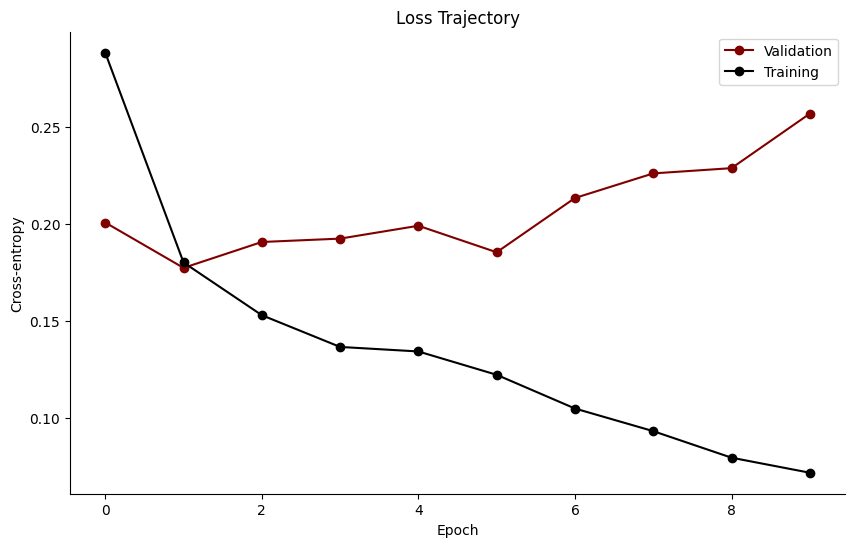

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(10), h.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(10), h.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

22/22 [==============================] - 0s 1ms/step


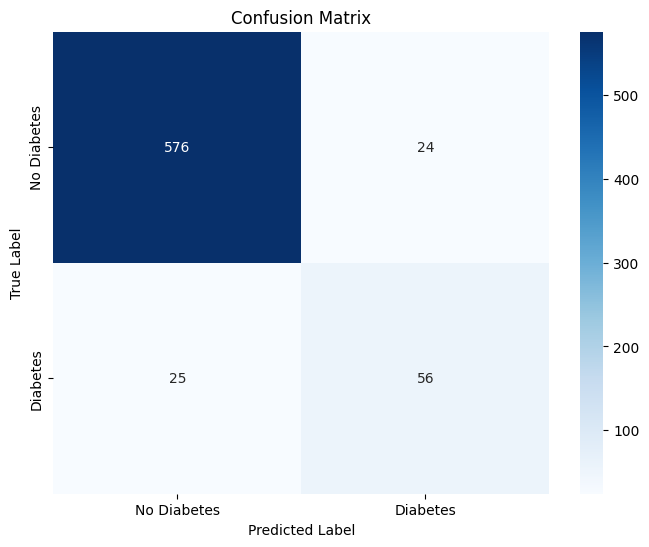

              precision    recall  f1-score   support

 No Diabetes       0.96      0.96      0.96       600
    Diabetes       0.70      0.69      0.70        81

    accuracy                           0.93       681
   macro avg       0.83      0.83      0.83       681
weighted avg       0.93      0.93      0.93       681



In [89]:
# Predict classes using the test set
y_pred = model.predict(X_test_transformed)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print classification report for precision, recall, f1-score
print(classification_report(y_test, y_pred_classes, target_names=['No Diabetes', 'Diabetes']))

In [142]:
# Split data into X and y
X = data.drop('diagnosis', axis=1)
y = data['diagnosis'].astype(int)

# Split original data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Bundle preprocessing for numerical and categorical data into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply the preprocessor to the training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Apply SMOTE only to the preprocessed training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# Split the resampled training data into final training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

# Get the number of features from the transformed data
input_shape = X_train_resampled.shape[1]

# Check the class distribution after applying SMOTE
print("Before SMOTE:")
print(y_train.value_counts())

print("After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Before SMOTE:
diagnosis
0    2400
1     320
Name: count, dtype: int64
After SMOTE:
diagnosis
0    2400
1    2400
Name: count, dtype: int64


/home/carrc4/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [207]:
# Create a new model using TensorFlow/Keras, more similar to your class example
def build_smote_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=[input_shape]),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [208]:
# Build the model
smote_model = build_smote_model(input_shape)

# Fit the model
smote_h = smote_model.fit(X_train_resampled, y_train_resampled, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
150/150 [==============================] - 1s 2ms/step - loss: 0.4923 - accuracy: 0.7556 - val_loss: 0.2421 - val_accuracy: 0.9135
Epoch 2/10
150/150 [==============================] - 0s 1ms/step - loss: 0.2904 - accuracy: 0.8877 - val_loss: 0.2145 - val_accuracy: 0.9198
Epoch 3/10
150/150 [==============================] - 0s 1ms/step - loss: 0.2387 - accuracy: 0.9102 - val_loss: 0.1718 - val_accuracy: 0.9375
Epoch 4/10
150/150 [==============================] - 0s 1ms/step - loss: 0.2165 - accuracy: 0.9169 - val_loss: 0.1416 - val_accuracy: 0.9469
Epoch 5/10
150/150 [==============================] - 0s 1ms/step - loss: 0.1820 - accuracy: 0.9340 - val_loss: 0.1236 - val_accuracy: 0.9625
Epoch 6/10
150/150 [==============================] - 0s 1ms/step - loss: 0.1571 - accuracy: 0.9454 - val_loss: 0.0906 - val_accuracy: 0.9740
Epoch 7/10
150/150 [==============================] - 0s 1ms/step - loss: 0.1468 - accuracy: 0.9504 - val_loss: 0.0798 - val_accuracy: 0.9802
Epoch 

In [209]:
# Evaluate the model on the test data
loss, accuracy = smote_model.evaluate(X_test_transformed, y_test)
print("Accuracy:", accuracy)

22/22 [==============================] - 0s 1ms/step - loss: 0.2905 - accuracy: 0.9325
Accuracy: 0.9324522614479065


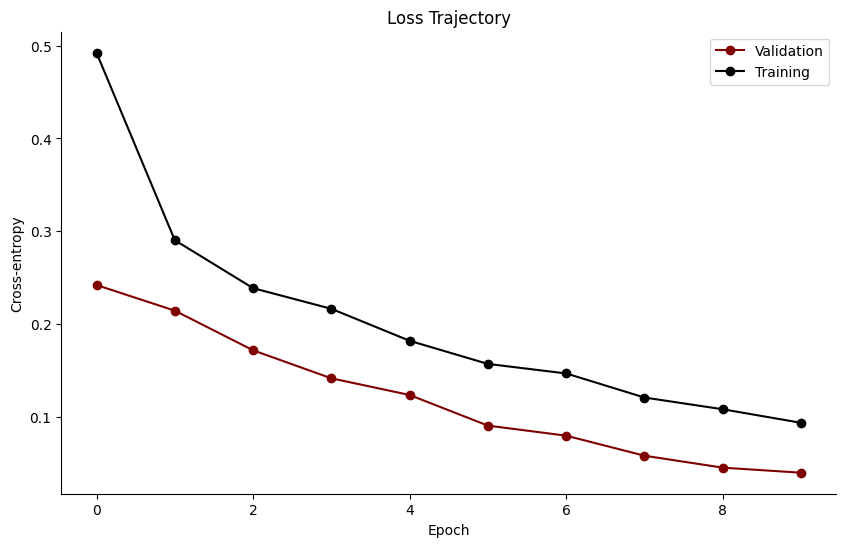

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(10), smote_h.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(10), smote_h.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

22/22 [==============================] - 0s 777us/step


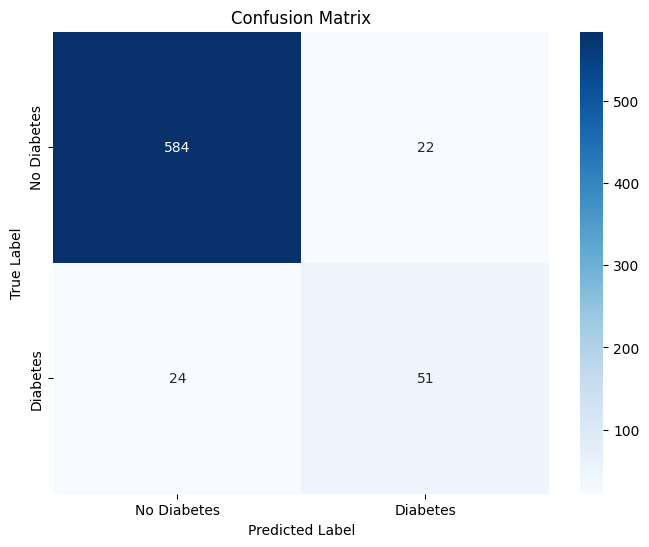

              precision    recall  f1-score   support

 No Diabetes       0.96      0.96      0.96       606
    Diabetes       0.70      0.68      0.69        75

    accuracy                           0.93       681
   macro avg       0.83      0.82      0.83       681
weighted avg       0.93      0.93      0.93       681



In [211]:
# Predict classes using the test set
y_pred = smote_model.predict(X_test_transformed)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print classification report for precision, recall, f1-score
print(classification_report(y_test, y_pred_classes, target_names=['No Diabetes', 'Diabetes']))